In [1]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Here we are creating a directory in which we are storing kaggle credentials json file
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [3]:
# Downloading data directly from kaggle
!kaggle datasets download -d alihussainkhan24/red-rot-sugarcane-disease-leaf-dataset

 99% 1.96G/1.97G [00:30<00:00, 118MB/s]
100% 1.97G/1.97G [00:30<00:00, 68.3MB/s]


In [4]:
# Downloaded data in in zip file so we need to extract it
import zipfile
zip_ref = zipfile.ZipFile('/content/red-rot-sugarcane-disease-leaf-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [40]:
# Importing liabraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Conv2D
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [6]:
# Our data is not in correct folder structure to let's correct it
!mv "/content/Images/test set" "/content/test" # moving 'test set' folder to /content

In [7]:
!mv "/content/Images" "/content/train" # renaming Images folder to train

In [8]:
# renaming Healthy to healthy and Unhealthy to unhealthy in train set
!mv "/content/train/Healthy" "/content/train/healthy"

In [9]:
!mv "/content/train/Unhealthy" "/content/train/unhealthy"

In [10]:
# Defining out image shape and batch_size
input_shape = (224,224,3)
batch_size = 32

# Now we need to prepare our train, valid, test dataset variables
train = tf.keras.utils.image_dataset_from_directory('train', labels='inferred',label_mode='int'
                                                    ,class_names=None,color_mode='rgb',shuffle=True
                                                    ,batch_size=batch_size,image_size=input_shape[:2]
                                                    ,validation_split=0.3, interpolation='bilinear'
                                                    ,subset='training',seed=42)

valid = tf.keras.utils.image_dataset_from_directory('train', labels='inferred',label_mode='int'
                                                    ,class_names=None,color_mode='rgb',shuffle=True
                                                    ,batch_size=batch_size,image_size=input_shape[:2]
                                                    ,validation_split=0.3, interpolation='bilinear'
                                                    ,subset='validation',seed=42)

test = tf.keras.utils.image_dataset_from_directory('test', labels='inferred',label_mode='int'
                                                    ,class_names=None,color_mode='rgb',shuffle=True
                                                    ,batch_size=batch_size,image_size=input_shape[:2]
                                                    ,validation_split=0.0, interpolation='bilinear'
                                                    ,seed=42)

Found 864 files belonging to 2 classes.
Using 605 files for training.
Found 864 files belonging to 2 classes.
Using 259 files for validation.
Found 115 files belonging to 2 classes.


In [11]:
# Getting soe basic info about our dataset
print("Total images in training set : ",(train.cardinality()*32).numpy())
print("Total images in validation set : ",(valid.cardinality()*32).numpy())
print("Total images in testing set : ",(test.cardinality()*32).numpy())

# Checking shape of out images
for train_images,train_labels in train.take(1):break
for valid_images,valid_labels in valid.take(1):break
for test_images,test_labels in test.take(1):break

print("Shape of images in train set : ",train_images.shape)
print("Shape of images in valid set : ",valid_images.shape)
print("Shape of images in test set : ",test_images.shape)

Total images in training set :  608
Total images in validation set :  288
Total images in testing set :  128
Shape of images in train set :  (32, 224, 224, 3)
Shape of images in valid set :  (32, 224, 224, 3)
Shape of images in test set :  (32, 224, 224, 3)


In [12]:
# Defining out class names
class_names = ['healthy','unhealthy','unhealthy']

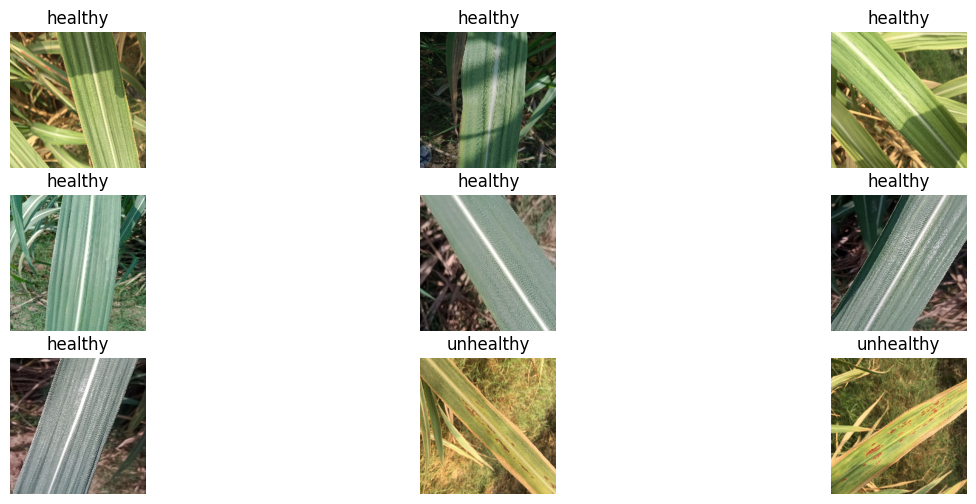

In [13]:
# Setting up figure size
plt.figure(figsize=(15,6))

# Plotting images of data
for index in range(9):
  plt.subplot(3,3,index+1)
  plt.imshow(train_images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(class_names[train_labels[index]])
  # plt.show()

In [14]:
# Now we need to perform augmetation to our data
random_flip = tf.keras.layers.RandomFlip('horizontal_and_vertical')
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
random_rotate = tf.keras.layers.RandomRotation(0.3)
random_brightness = tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0))

augmentations = [random_flip, random_zoom, random_rotate, random_brightness]

# Applying augmentation on training data
for augmentation in augmentations:
  train = train.map(lambda images,labels:(augmentation(images),labels))

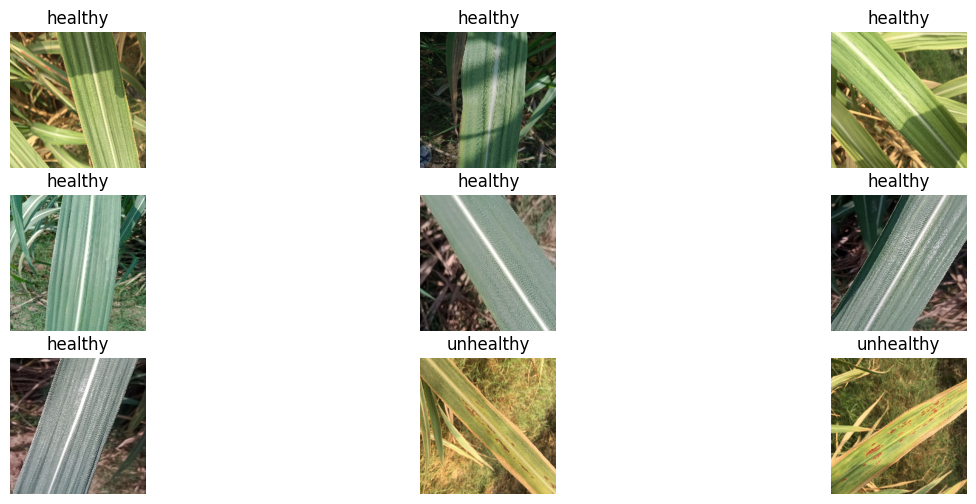

In [15]:
# Setting up figure size
plt.figure(figsize=(15,6))

# Plotting images of data after augmentation
for index in range(9):
  plt.subplot(3,3,index+1)
  plt.imshow(train_images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(class_names[train_labels[index]])
  # plt.show()

In [16]:
# Importing out VGG16 model
base_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
# Here we are freezing our model our base_model
base_model.trainable = False

In [18]:
# Getting a quick summary of our model so far
base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)

Model: "vgg16"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 input_1 (InputLayer)                                 [(None, 224, 224, 3)]                           0                 N          
                                                                                                                                   
 block1_conv1 (Conv2D)                                (None, 224, 224, 64)                            1792              N          
                                                                                                                                   
 block1_conv2 (Conv2D)                                (None, 224, 224, 64)                            36928             N          
                                                             

In [19]:
# We need to define a VGGPreprocessing class so that we can apply
class VGG16Preprocessing(tf.keras.layers.Layer):

  def call(self,inputs):

    '''
    This function receives images as input and returns processed images by scaling images
    '''
    return tf.keras.applications.vgg16.preprocess_input(inputs)

In [59]:
# Defining our sequential model and building it by adding base_model to it and then adding layers of Dense Map
model = Sequential()
model.add(VGG16Preprocessing())
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(3,activation='softmax'))

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [61]:
Early_stopping = EarlyStopping(monitor='val_loss'
                              ,patience=10
                              ,restore_best_weights=True,
                               verbose='auto')

Model_check_point = ModelCheckpoint(filepath='/content/drive/MyDrive/Sugarcane_red_rot_classification_project'
                                   ,monitor='val_loss'
                                   ,save_best_only=True)

In [62]:
history = model.fit(train,verbose='auto',
          epochs=10,
          callbacks=[Early_stopping, Model_check_point],
          validation_split=0, validation_data=valid
          ,shuffle=True,)

Epoch 1/10
19/19 [==============================] - 58s 2s/step - loss: 8.9492 - sparse_categorical_accuracy: 0.6876 - val_loss: 4.6019 - val_sparse_categorical_accuracy: 0.8533
Epoch 2/10
19/19 [==============================] - 57s 2s/step - loss: 3.3342 - sparse_categorical_accuracy: 0.8645 - val_loss: 2.8782 - val_sparse_categorical_accuracy: 0.8842
Epoch 3/10
19/19 [==============================] - 52s 2s/step - loss: 2.6105 - sparse_categorical_accuracy: 0.8893 - val_loss: 3.0606 - val_sparse_categorical_accuracy: 0.8919
Epoch 4/10
19/19 [==============================] - 53s 2s/step - loss: 2.3535 - sparse_categorical_accuracy: 0.8810 - val_loss: 1.8017 - val_sparse_categorical_accuracy: 0.9459
Epoch 5/10
19/19 [==============================] - 50s 2s/step - loss: 3.0339 - sparse_categorical_accuracy: 0.8992 - val_loss: 4.0475 - val_sparse_categorical_accuracy: 0.8726
Epoch 6/10
19/19 [==============================] - 50s 2s/step - loss: 4.2299 - sparse_categorical_accuracy: 

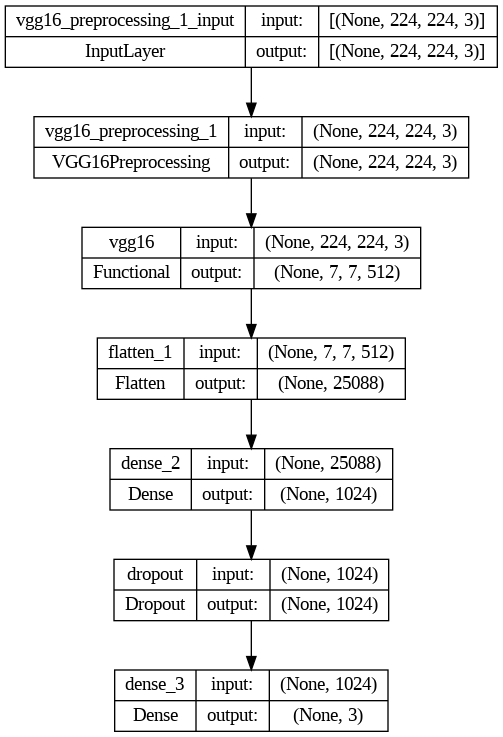

In [63]:
# plotting model
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True,show_dtype=False,show_layer_names=True,rankdir='TB',
                          expand_nested=False,dpi=96,layer_range=None,show_layer_activations=False)

In [64]:
history.history

{'loss': [8.94922161102295,
  3.334151029586792,
  2.610509157180786,
  2.35351824760437,
  3.0338854789733887,
  4.2298760414123535,
  2.0218286514282227,
  1.776587963104248,
  1.5045864582061768,
  3.2493817806243896],
 'sparse_categorical_accuracy': [0.6876032948493958,
  0.8644627928733826,
  0.8892561793327332,
  0.8809917569160461,
  0.8991735577583313,
  0.871074378490448,
  0.9206611514091492,
  0.9305785298347473,
  0.9404958486557007,
  0.902479350566864],
 'val_loss': [4.601920127868652,
  2.8782479763031006,
  3.0606110095977783,
  1.801653265953064,
  4.047464370727539,
  2.525050401687622,
  1.5743662118911743,
  1.5887314081192017,
  2.028914451599121,
  2.225013256072998],
 'val_sparse_categorical_accuracy': [0.8532818555831909,
  0.88416987657547,
  0.8918918967247009,
  0.9459459185600281,
  0.8725868463516235,
  0.8996139168739319,
  0.953667938709259,
  0.953667938709259,
  0.9305019378662109,
  0.9305019378662109]}

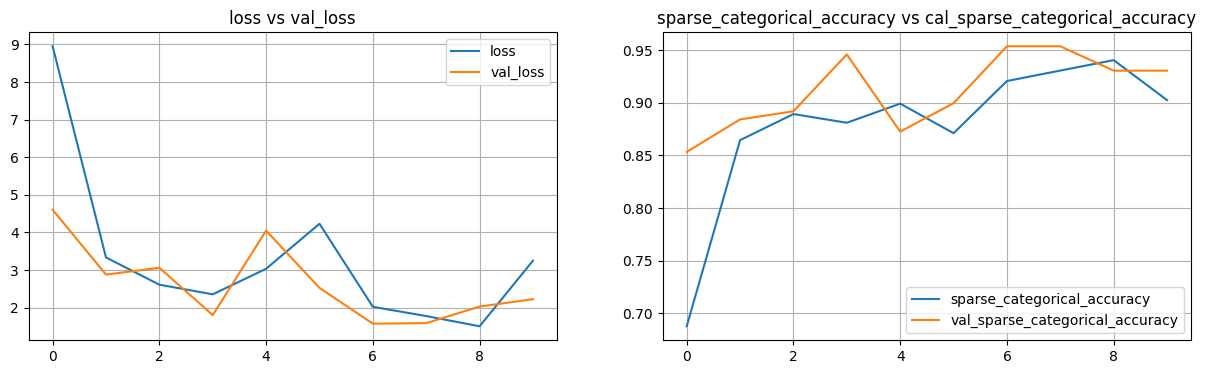

In [67]:
# Plotting our model's accuracy and loss
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss vs val_loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'],label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'],label='val_sparse_categorical_accuracy')
plt.title('sparse_categorical_accuracy vs cal_sparse_categorical_accuracy')
plt.grid()
plt.legend()

In [68]:
# Now it's time to evaluate our model
loss,accuracy = model.evaluate(test)

4/4 [==============================] - 1s 126ms/step - loss: 7.3525 - sparse_categorical_accuracy: 0.8000


In [69]:
# Displaying loss and accuracy on test data
print("Loss on test data : ",round(loss,2))
print("Accuracy on test data : ",str(round(accuracy*100,2))+" %")

Loss on test data :  7.35
Accuracy on test data :  80.0 %


In [70]:
# Calculating Predictions
y_pred = model.predict(test)
y_pred = np.argmax(y_pred,axis=1)
print(y_pred)

4/4 [==============================] - 1s 139ms/step
[1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1
 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0]


In [ ]:
# Here we are taking out our labels from test set
y_labels=list()
for images,labels in test.as_numpy_iterator():y_labels.extend(labels)

In [84]:
confusionMatrix = tf.math.confusion_matrix(y_labels,y_labels)
print("Confusion Matrix")
print("*"*50)
print(confusionMatrix.numpy())

Confusion Matrix
**************************************************
[[61  0]
 [ 0 54]]


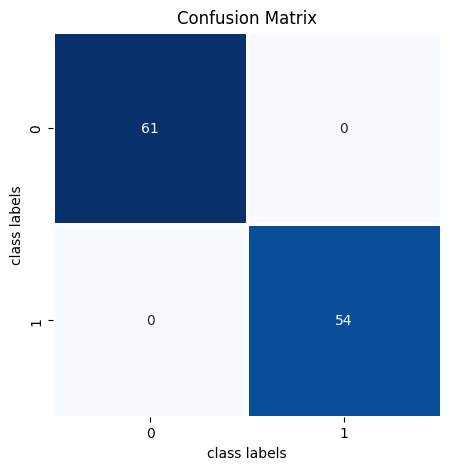

In [86]:
# plotting confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(data=confusionMatrix,annot=True,fmt='',linewidths=1,linecolor='white',cbar=False,cmap='Blues')
plt.xlabel('class labels'),plt.ylabel('class labels'),plt.title('Confusion Matrix')
plt.show()

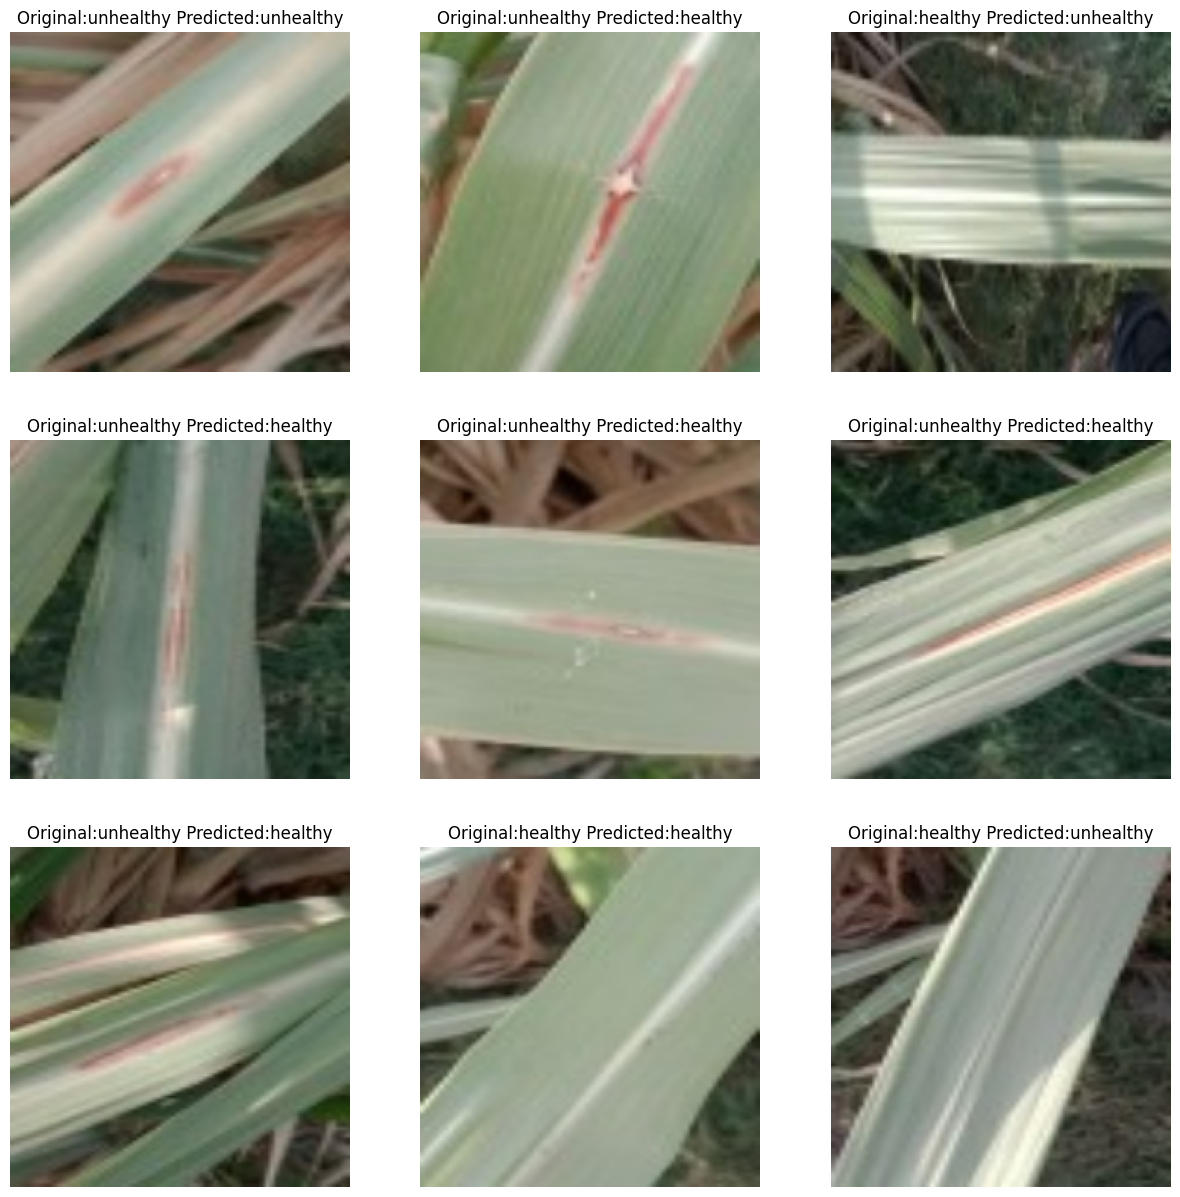

In [91]:
# Plotting Predictions
plt.figure(figsize=(15,15))
for images,labels in test.take(1):break
for index in range(9):
  plt.subplot(3,3,index+1)
  plt.imshow(images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title('Original:' + class_names[labels[index]] + ' Predicted:' + class_names[y_pred[index]])